# Build CNN Classification Model 

**Using the Human Recognition Activity dataset, build a multivariate CNN model to classify the activity for each individual:**

    WALKING
    WALKING_UPSTAIRS
    WALKING_DOWNSTAIRS
    SITTING
    STANDING
    LAYING
  
**The input data, which is multiple time series, have been pre-processed and cleaned to nine univariate time series of the same length in timesteps (128), with thousands of samples (they can be found in the train and test folders).** 
 
**The nine time series are:**

    X, Y, Z time series for body acceleration (3)
    X, Y, Z time series for total acceleration (3)
    X, Y, Z time series for body gyro (3)
    
**The multivariate time series need to be loaded and combined into supervised training and test sets for use in TensorFlow, i.e. input of *N* x *T* x *D* or (*N*, 128, 9). The target output is simply an array of integers.**

* **After building a basic CNN model, compare to another CNN model that uses the *static features* only. The features-only data has already been prepared in the X_train.txt and X_test.txt files found in the main folder. Since this is data typically used in more traditional machine-learning methods, you can also compare to some SciKit-Learn models.** 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D, GlobalAveragePooling1D, Flatten
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

np.random.seed(0)
tf.random.set_seed(0)

%matplotlib inline

In [2]:
# Check data is there

from os import listdir

dir_path = 'data/UCI-HAR/UCI HAR Dataset/train'

res = listdir(dir_path)
print(res)

['Inertial Signals', 'subject_train.txt', 'X_train.txt', 'y_train.txt']


In [3]:
# Obtain constants by inspecting the files

# No of timesteps
T = 128

# Length of training set
Ntrain = 7352

# Length of test set
Ntest = 2947

# No of time series
D = 9

# No of output classes (1-6)
K = 6

In [4]:
# Function to load time series and combine into 'supervised' X_train, y_train, X_test and y_test sets

def load_data():
    # Returns:
    # Xtrain (Ntrain x T x D), Ytrain (Ntrain)
    # Xtest (Ntest x T x D), Ytest (Ntest)
    
    Xtrain = np.zeros((Ntrain, T, D))
    Xtest = np.zeros((Ntest, T, D))
    
    # Training input
    ts_filenames = ['body_acc_x_train.txt', 
                    'body_gyro_x_train.txt', 
                    'total_acc_x_train.txt', 
                    'body_acc_y_train.txt', 
                    'body_gyro_y_train.txt', 
                    'total_acc_y_train.txt', 
                    'body_acc_z_train.txt', 
                    'body_gyro_z_train.txt', 
                    'total_acc_z_train.txt']
    
    ts_file_prefix = 'data/UCI-HAR/UCI HAR Dataset/train/'
    
    for d, fn in enumerate(ts_filenames):
        df = pd.read_csv(f'{ts_file_prefix}Inertial Signals/{fn}', header=None, delim_whitespace=True)
        
        # Ntrain x T
        x = df.to_numpy()
        Xtrain[:, :, d] = x
        
    # Training labels
    Ytrain = pd.read_csv(f'{ts_file_prefix}y_train.txt', header=None).to_numpy() - 1 
    Ytrain = Ytrain.flatten()
    
    # Test input
    ts_filenames = ['body_acc_x_test.txt', 
                    'body_gyro_x_test.txt', 
                    'total_acc_x_test.txt', 
                    'body_acc_y_test.txt', 
                    'body_gyro_y_test.txt', 
                    'total_acc_y_test.txt', 
                    'body_acc_z_test.txt', 
                    'body_gyro_z_test.txt', 
                    'total_acc_z_test.txt']
    
    ts_file_prefix = 'data/UCI-HAR/UCI HAR Dataset/test/'
    
    for d, fn in enumerate(ts_filenames):
        df = pd.read_csv(f'{ts_file_prefix}Inertial Signals/{fn}', header=None, delim_whitespace=True)
        
        # Ntest x T
        x = df.to_numpy()
        Xtest[:, :, d] = x
        
    # Test labels
    Ytest = pd.read_csv(f'{ts_file_prefix}y_test.txt', header=None).to_numpy() - 1 
    Ytest = Ytest.flatten()
    
    return Xtrain, Ytrain, Xtest, Ytest

In [5]:
X_train, y_train, X_test, y_test = load_data()

In [6]:
# (N x T x D)
print("X_train dimensions:", X_train.shape)

# (N)
print("y_train dimensions:", y_train.shape)

X_train dimensions: (7352, 128, 9)
y_train dimensions: (7352,)


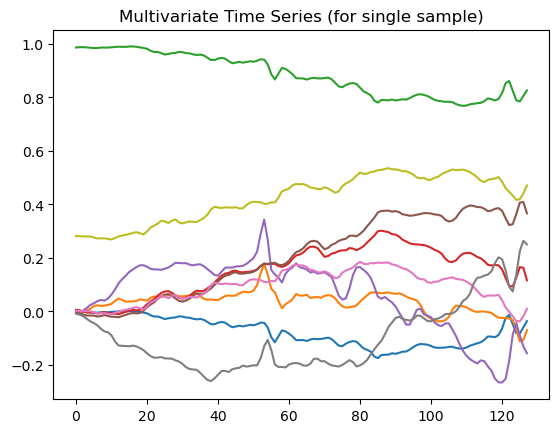

In [8]:
# Plot all nine time series for single sample

plt.plot(X_train[7000, :, :])
plt.title("Multivariate Time Series (for single sample)");

## Build CNN

**Unlike ANNs, you do not have to build a multi-tailed CNN to cope with multivariate time series, since you can declare the multiple dimensions in the `Input` layer. Increase `kernel_size` and `pool_size` parameters to cope with larger time series.**

In [9]:
i = Input(shape=(T, D))

x = Conv1D(32, 5, activation='relu')(i)
x = MaxPooling1D(3)(x)

x = Conv1D(64, 3, activation='relu')(x)
x = MaxPooling1D(2)(x)

x = Conv1D(128, 3, activation='relu')(x)
x = GlobalMaxPooling1D()(x)

x = Dense(K)(x)

model = Model(i, x)

In [10]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 9)]          0         
                                                                 
 conv1d (Conv1D)             (None, 124, 32)           1472      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 41, 32)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 39, 64)            6208      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 19, 64)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 17, 128)           24704 

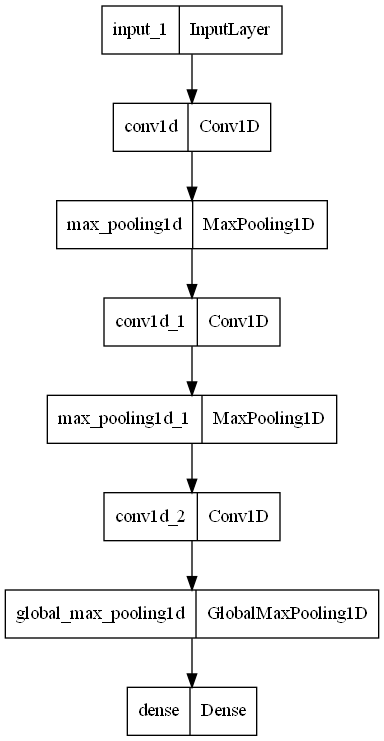

In [11]:
tf.keras.utils.plot_model(model)

In [12]:
# Create checkpoint - see data folder for best model

check_point = ModelCheckpoint('data/best_model.h5', monitor='val_accuracy', save_best_only=True)

In [13]:
model.compile(loss=SparseCategoricalCrossentropy(from_logits=True), optimizer='adam', metrics=['accuracy'])

In [14]:
r = model.fit(X_train, 
              y_train, 
              epochs=15, 
              callbacks=[check_point], 
              validation_data=(X_test, y_test))

Epoch 1/15
230/230 [==============================] - 3s 9ms/step - loss: 0.4026 - accuracy: 0.8621 - val_loss: 0.2524 - val_accuracy: 0.8996
Epoch 2/15
230/230 [==============================] - 2s 7ms/step - loss: 0.1251 - accuracy: 0.9505 - val_loss: 0.2373 - val_accuracy: 0.9067
Epoch 3/15
230/230 [==============================] - 2s 7ms/step - loss: 0.1119 - accuracy: 0.9544 - val_loss: 0.1970 - val_accuracy: 0.9230
Epoch 4/15
230/230 [==============================] - 2s 7ms/step - loss: 0.1009 - accuracy: 0.9574 - val_loss: 0.1905 - val_accuracy: 0.9196
Epoch 5/15
230/230 [==============================] - 2s 7ms/step - loss: 0.0966 - accuracy: 0.9596 - val_loss: 0.2064 - val_accuracy: 0.9203
Epoch 6/15
230/230 [==============================] - 2s 7ms/step - loss: 0.0885 - accuracy: 0.9625 - val_loss: 0.1994 - val_accuracy: 0.9237
Epoch 7/15
230/230 [==============================] - 2s 7ms/step - loss: 0.0923 - accuracy: 0.9637 - val_loss: 0.3134 - val_accuracy: 0.9074
Epoch 

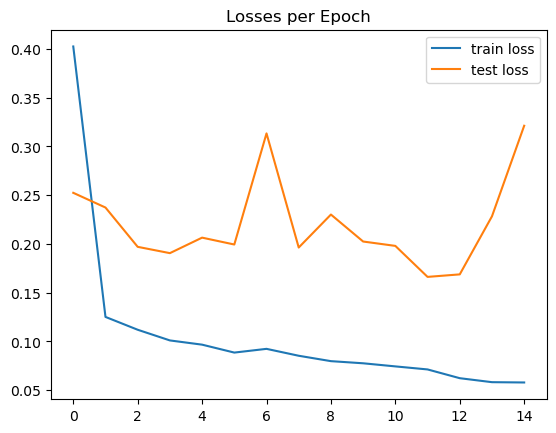

In [15]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.title("Losses per Epoch")
plt.legend();

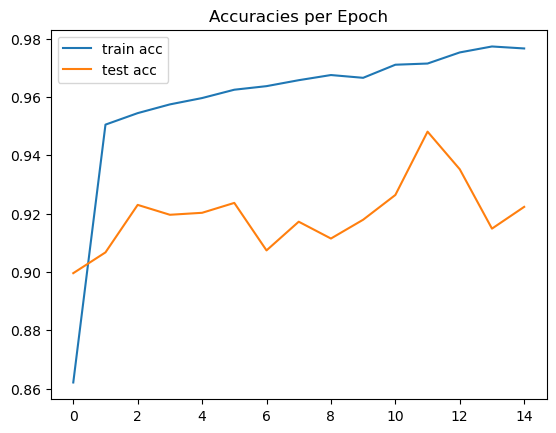

In [16]:
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='test acc')
plt.title("Accuracies per Epoch")
plt.legend();

**Even though the test accuracy and losses don't look as smoothly increasing or decreasing respectively, the model is learning the data, as seen by the training set performance.**

In [17]:
# Load best model

best_model = tf.keras.models.load_model('data/best_model.h5')

In [18]:
# Predict with best model

P_test = best_model.predict(X_test)

93/93 [==============================] - 0s 2ms/step


In [19]:
# Evaluate model accuracy

np.mean(np.argmax(P_test, axis=1) == y_test)

0.9480827960637936

**Approx. 95% accuracy is not a bad score, but compare with the the ANN models seen.**

## Build combined CNN

**Using *static features* as well as the time series, build a combined CNN, i.e. combine feature-based ANN (normal feed-forward network) with time-series CNN above. Luckily we have been given the input data for the features-only data (`X_train.txt` and `y_train.txt`). The target data can remain the same.**

**For the feature-based ANN, it is advised to standardize the input data.** 

In [20]:
from sklearn.preprocessing import StandardScaler

def load_features():
    # Returns:
    # X_train (Ntrain x D)
    # X_test (Ntest x D)
    
    # Training input
    df = pd.read_csv('data/UCI-HAR/UCI HAR Dataset/train/X_train.txt', header=None, delim_whitespace=True)
    
    feat_train = df.to_numpy()
    
    # Test input
    df = pd.read_csv('data/UCI-HAR/UCI HAR Dataset/test/X_test.txt', header=None, delim_whitespace=True)
    
    feat_test = df.to_numpy()
    
    scaler = StandardScaler()
    feat_train = scaler.fit_transform(feat_train)
    feat_test = scaler.transform(feat_test)
    
    return feat_train, feat_test

In [21]:
feat_train, feat_test = load_features()

In [22]:
# (N x D)

print("Train dimensions:", feat_train.shape)

print("Test dimensions", feat_test.shape)

Train dimensions: (7352, 561)
Test dimensions (2947, 561)


In [23]:
# Obtain number of features

D_feat = feat_train.shape[1]

In [24]:
# ------------ CNN model

i = Input(shape=(T, D))

x = Conv1D(32, 5, activation='relu')(i)
x = MaxPooling1D(3)(x)

x = Conv1D(64, 3, activation='relu')(x)
x = MaxPooling1D(2)(x)

x = Conv1D(128, 3, activation='relu')(x)
x = GlobalMaxPooling1D()(x)

# ------------ ANN model

i2 = Input(shape=(D_feat,))

x2 = Dense(64, activation='relu')(i2)

# ----------- Combine models

x = Concatenate()([x, x2])

x = Dense(K)(x)

model = Model([i, i2], x)

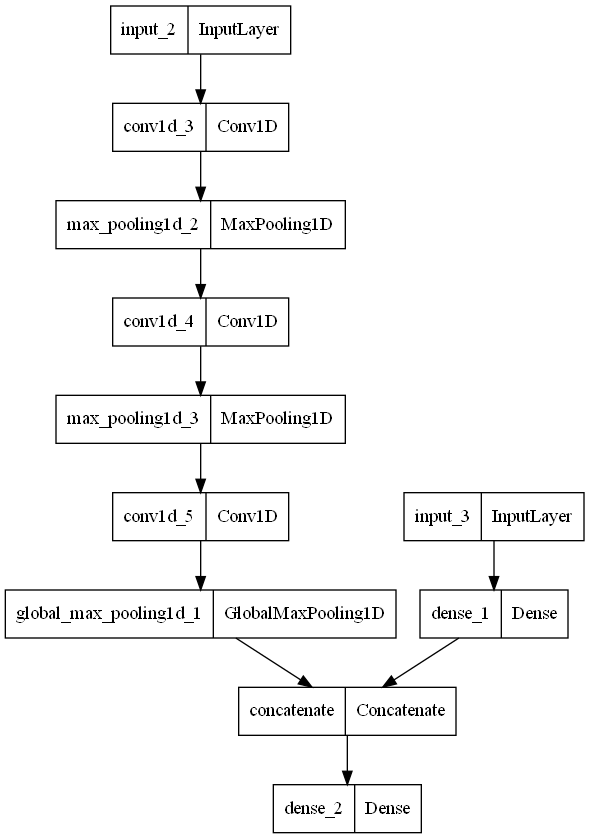

In [25]:
tf.keras.utils.plot_model(model)

In [26]:
# Create checkpoint - see in data folder

check_point3 = ModelCheckpoint('data/best_model_combined.h5', monitor='val_accuracy', save_best_only=True)

In [27]:
model.compile(loss=SparseCategoricalCrossentropy(from_logits=True), optimizer='adam', metrics=['accuracy'])

In [28]:
# Add the list of time series to list of features in input

r = model.fit([X_train, feat_train], 
              y_train, 
              epochs=15, 
              callbacks=[check_point3], 
              validation_data=([X_test, feat_test], y_test))

Epoch 1/15
230/230 [==============================] - 2s 8ms/step - loss: 0.2255 - accuracy: 0.9157 - val_loss: 0.1360 - val_accuracy: 0.9515
Epoch 2/15
230/230 [==============================] - 2s 7ms/step - loss: 0.0732 - accuracy: 0.9701 - val_loss: 0.1432 - val_accuracy: 0.9498
Epoch 3/15
230/230 [==============================] - 2s 7ms/step - loss: 0.0554 - accuracy: 0.9770 - val_loss: 0.1093 - val_accuracy: 0.9627
Epoch 4/15
230/230 [==============================] - 2s 7ms/step - loss: 0.0429 - accuracy: 0.9835 - val_loss: 0.1181 - val_accuracy: 0.9617
Epoch 5/15
230/230 [==============================] - 2s 7ms/step - loss: 0.0364 - accuracy: 0.9857 - val_loss: 0.1119 - val_accuracy: 0.9644
Epoch 6/15
230/230 [==============================] - 2s 7ms/step - loss: 0.0340 - accuracy: 0.9867 - val_loss: 0.1174 - val_accuracy: 0.9623
Epoch 7/15
230/230 [==============================] - 2s 7ms/step - loss: 0.0282 - accuracy: 0.9893 - val_loss: 0.1845 - val_accuracy: 0.9427
Epoch 

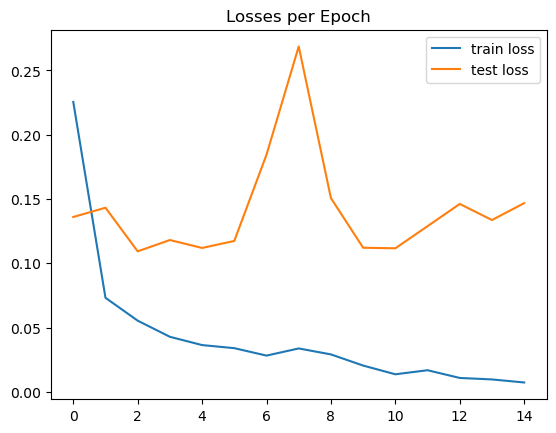

In [29]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.title("Losses per Epoch")
plt.legend();

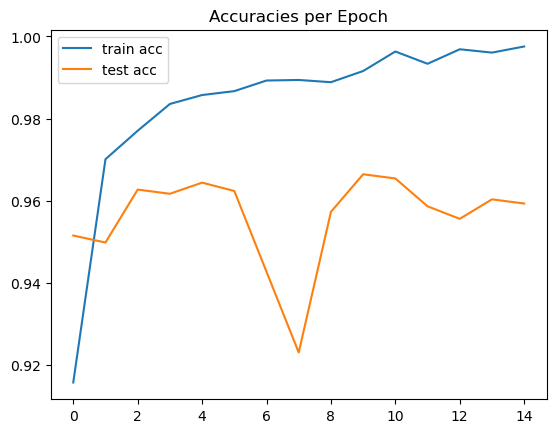

In [30]:
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='test acc')
plt.title("Accuracies per Epoch")
plt.legend();

**Note the big spike in test losses and big dip in test accuracy.**

In [31]:
# Load best combined model

best_model = tf.keras.models.load_model('data/best_model_combined.h5')

In [32]:
# Make predictions with best combined model

Ptest = best_model.predict([X_test, feat_test])

93/93 [==============================] - 0s 2ms/step


In [33]:
# Evaluate combined model accuracy

np.mean(np.argmax(Ptest, axis=1) == y_test)

0.9664065151001018

**With the added information of the static features, the combined model has better accuracy in its predictions, which shows that using data from different sources can improve model learning.**

**Compare to the combined ANN model, or other models using this dataset.**